In [16]:
from collections import defaultdict
import csv 
from csv import reader
from scipy.optimize import linear_sum_assignment
#from PIL import Image as im
from IPython.core.display import Image, display
import requests
from io import BytesIO
import json 

'''
Ambiguity
    Multiple Options > A/M
    Definition, Location > A/L
    Definition, Destination/Intention > A/D
    Definition, Kind/Type > A/K
    Definition, Time > A/T
    Gouping > A/G

Uncertainty > U

Mistakes/Bad Data
    Annotator mistakes > M/A
    Bad question/bad images > M/B

Misc/need reclassifying > ~

Question with multiple classification will have '.' between the classificiations
ex: A/M.A/L.M/B)
'''

input_csv = "csv_results_ambiguity.csv"
data = []
with open(input_csv) as read_obj:
    csv_reader = csv.DictReader(read_obj)
    for row in csv_reader:
        data.append(row)


In [ ]:
'''
Display by classification
'''
search_item = 'A/L'

for row in data:
    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    
    if search_item in labels:
        groups = []

        new_questions = json.loads(row['Answer.answer_questions'])
        for i, g in enumerate(json.loads(row['Answer.answer_groups'])):
            group = []
            new_question = new_questions[i]
            for x in g:
                group.append(x['content'])
            groups.append({new_question: group})
        print(row['Input.questionStr'])
        print(row['Input.imgUrl'])
        print(labels)

        image_url = row['Input.imgUrl'].strip('"')
        display(Image(url=image_url))
       

In [ ]:
'''
Display by number of classifications
'''
search_num = 3

for row in data:
    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    
    if len(labels) >= search_num:
        groups = []

        new_questions = json.loads(row['Answer.answer_questions'])
        for i, g in enumerate(json.loads(row['Answer.answer_groups'])):
            group = []
            new_question = new_questions[i]
            for x in g:
                group.append(x['content'])
            groups.append({new_question: group})
        print(row['Input.questionStr'])
        print(row['Input.imgUrl'])
        print(groups)
        print(labels)

        image_url = row['Input.imgUrl'].strip('"')
        display(Image(url=image_url))

There are 295 examples, with 179 good ones and 116 bad ones.


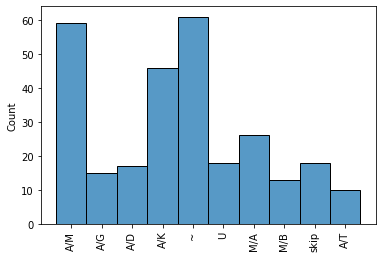

In [8]:
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np 

# Histogram
num_mistakes_other = 0
num_to_keep = 0
total = 0
# histogram 
acceptable = ['A/M', 'A/G', 'A/D', 'A/K', 'A/T', 'U', 'M/A', 'M/B', 'skip', '~']
to_keep = ['A/M', 'A/G', 'A/D', 'A/K', 'A/T',  '~']
all_labels = []
for row in data:
    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    for lab in labels:
        if lab in acceptable:
            all_labels.append(lab)
    total += 1
    for lab in labels:
        if lab in to_keep: 
            num_to_keep += 1 
            break
        else:
            num_mistakes_other  += 1
            break



g = sns.histplot(all_labels)

plt.xticks(rotation=90)


print(f"There are {total} examples, with {num_to_keep} good ones and {num_mistakes_other} bad ones.")

{'A/M': [0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1], 'A/G': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'A/D': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'A/K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], '~': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'U': [0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0], 'M/A': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'M/B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'skip': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'A/T': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'A/L': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
[[0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


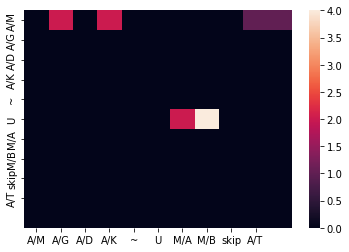

In [35]:
import numpy as np
import pandas as pd
import seaborn  as sns
from matplotlib import pyplot as plt

'A/M 0 , A/G 1, A/D 2, A/K 3, ~ 4, U 5, M/A 6, M/B 7, skip 8, A/T 9'
intersection_dict = {'A/M': [0,0,0,0,0,0,0,0,0,0,0], 
                    'A/G': [0,0,0,0,0,0,0,0,0,0,0], 
                    'A/D': [0,0,0,0,0,0,0,0,0,0,0], 
                    'A/K': [0,0,0,0,0,0,0,0,0,0,0], 
                    '~': [0,0,0,0,0,0,0,0,0,0,0], 
                    'U': [0,0,0,0,0,0,0,0,0,0,0], 
                    'M/A': [0,0,0,0,0,0,0,0,0,0,0], 
                    'M/B': [0,0,0,0,0,0,0,0,0,0,0], 
                    'skip': [0,0,0,0,0,0,0,0,0,0,0], 
                    'A/T': [0,0,0,0,0,0,0,0,0,0,0],
                    'A/L': [0,0,0,0,0,0,0,0,0,0,0]}

# Heatmap
for row in data:
    temp = row['Answer.skip_reason'].strip('"')
    labels = temp.split('.')
    #print(labels)
    nlabels = len(labels)
    if nlabels > 1:
        for lab in range(1, nlabels-1):
            if labels[lab] == 'A/M':
                intersection_dict[labels[0]][0] += 1
            if labels[lab] == 'A/G':
                intersection_dict[labels[0]][1] += 1
            if labels[lab] == 'A/D':
                intersection_dict[labels[0]][2] += 1
            if labels[lab] == 'A/K':
                intersection_dict[labels[0]][3] += 1
            if labels[lab] == '~':
                intersection_dict[labels[0]][4] += 1
            if labels[lab] == 'U':
                intersection_dict[labels[0]][5] += 1
            if labels[lab] == 'M/A':
                intersection_dict[labels[0]][6] += 1
            if labels[lab] == 'M/B':
                intersection_dict[labels[0]][7] += 1
            if labels[lab] == 'skip':
                intersection_dict[labels[0]][8] += 1
            if labels[lab] == 'A/T':
                intersection_dict[labels[0]][9] += 1
            if labels[lab] == 'A/L':
                intersection_dict[labels[0]][10] += 1
    
print(intersection_dict)

Yrows = ['A/M', 'A/G', 'A/D', 'A/K', '~', 'U', 'M/A', 'M/B', 'skip', 'A/T']
Xrows = ['A/M', 'A/G', 'A/D', 'A/K', '~', 'U', 'M/A', 'M/B', 'skip', 'A/T']

intersection_2d_array = []
for types in intersection_dict: 
    intersection_2d_array.append(intersection_dict[types])

print(intersection_2d_array)
ax = sns.heatmap(intersection_2d_array, yticklabels=Yrows, xticklabels = Xrows)
#ax.set_yticks(Yrows)
plt.show()

                
        